# Pairwise Comparison for Single Environment

In this file we do a pairwise comparison for policies trained in a single environment but using different seeds and/or training algorithms.

We look at:

- Self-play
- Cross-play between policies trained with the same algorithm but different seeds
- Cross-play between policies trained with different algorithms


## Notation

- **Self-play** refers to pairings of policies that trained together
- **Cross-play** refers to pairings of policies that were not trained together

In [1]:
import sys
import pathlib

# Add ba-posgmcp/experiments/Driving directory to python Path
# So we can import experiment specific code
sys.path.append("/home/jonathon/code/ba-posgmcp/experiments/Driving")

import os.path as osp
from typing import List, Any, Optional, Tuple
from itertools import permutations, product

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import posggym

import exp_utils
import plot_utils

# Data Loading

Firstly lets load the data and do a little cleaning and setup by:

1. removing unused columns
2. add columns for agent policy training environment and reasoning level

In [2]:
rl_results_dir = "analysis_v2/pairwise_comparison_initseed0_numseeds1_2022-08-03_03-04-158xauqalb"

columns_to_drop = [
    'Unnamed: 0', 
    'episode_step_limit', 
    'time_limit', 
    'use_checkpointing',
    'search_time_mean', 
    'search_time_std', 
    'update_time_mean', 
    'update_time_std',
    'reinvigoration_time_mean', 
    'reinvigoration_time_std', 
    'policy_calls_mean', 
    'policy_calls_std', 
    'inference_time_mean', 
    'inference_time_std',
    'episode_dones',
]
rl_df = plot_utils.import_results(rl_results_dir, columns_to_drop, False)

rl_df.columns
plot_utils.validate_and_display(rl_df, False)

Agent IDs: [0 1]
Test Env: Driving7x7RoundAbout-v0
Seeds: [0]
Policy K: ['-1' '0' '1' '2' '3' '4' 'BR']
Policy Names: ['PPOPolicy_pi_0' 'PPOPolicy_pi_1' 'PPOPolicy_pi_2' 'PPOPolicy_pi_3'
 'PPOPolicy_pi_4' 'PPOPolicy_pi_BR' 'RandomPolicy']
Train Envs:: ['Driving7x7RoundAbout-v0']
Train Seeds: [0 1 2 3 4]
Train Algorithms: ['klr']
Coplayer Policy K: ['-1' '0' '1' '2' '3' '4' 'BR']
Coplayer Train Seed: [0 1 2 3 4]
Num rows/entries: 1470
Num experiments: 735


# The environment

Here we can see the layout for the environment. Noting that the start and destination positions for each agent changes each episode. Agents always start in a cell along the bottom or right side of the grid and have a destination in a cell along the top or left side of the grid.  

Agents can observe a rectangular area around their current location that that contains 3 cells in front, 1 behind and 1 cell to each side (total 4x3=12 cells), shown by the highlighted cells in the images. 

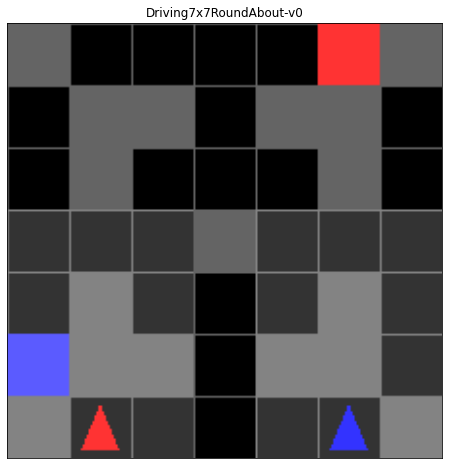

In [3]:
plot_utils.plot_environment(rl_df["env_name"].unique()[0])    
plt.show()

# Plotting

For this evaluation we have multiple degrees of variation:

1. Policy reasoning level ('K') - the reasoning level of an agent policy 
  - `BR` is the best response policy for a distribution over the policies `[-1, 0, 1, 2, 3, 4]`
  - `SP` is the policy trained using the `self-play` algorithm.
2. Train Seeds ('train_seed') - the training seed of the agent policy
  - 5 different seeds were used for each experiment
3. Training algorithm ('train_alg') - The algorithm used to train the agent policy
  - `KLR` - K-level reasoning algorithm (specifically the SyKLRBR algorithm)
  - `SP` - self-play


## Helper Functions

The following are some helper functions for later plots.

In [4]:
def get_all_rl_pw_mean_values(plot_df, y_key: str):
    policy_IDs = plot_df["K"].unique()
    policy_IDs.sort()
    
    xp_pw_returns = np.zeros((len(policy_IDs), len(policy_IDs)))
    sp_pw_returns = np.zeros((len(policy_IDs), len(policy_IDs)))

    for r, row_policy_id in enumerate(policy_IDs):
        for c, col_policy_id in enumerate(policy_IDs):
            sp_return, xp_return = plot_utils.get_mean_pairwise_values(
                plot_df,
                row_conds=[("K", "==", row_policy_id)],
                row_seed_key="train_seed",
                row_alg_key="train_alg",
                col_conds=[("K", "==", col_policy_id)],
                col_seed_key="train_seed",
                col_alg_key="train_alg",
                y_key=y_key
            )

            sp_pw_returns[r][c] = sp_return
            xp_pw_returns[r][c] = xp_return
    
    return policy_IDs, sp_pw_returns, xp_pw_returns

In [5]:
def plot_pairwise_policy_comparison(plot_df, 
                                    y_key: str,
                                    vrange=None,
                                    figsize=(20, 20),
                                    valfmt=None,
                                    average_duplicates: bool=True):
    """Plot results for each policy-seed pairings.
    
    This produces a grid of (grid)-plots:
    
    Outer-grid: train seed X train seed
    Inner-grid: K X K
    
    It is possible that the there are multiple pairings of the same policy K X train seed matchup.
    E.g. (agent 0 pi_0 vs agent 1 pi_1) and (agent 0 pi_1 vs agent 1 pi_0).
    In some cases we can just take the average of the two (e.g. when looking at times or returns).
    In such cases use `average_duplicates=True`.
    For cases where we can't take the average (e.g. for getting exp_id), set `average_duplicates=False`,
    in which case the first entry will be used.
    
    """
    if average_duplicates:
        print("Averaging duplicates. FYI")
    else:
        print("Not averaging duplicates. FYI.")

    train_seeds = plot_df["train_seed"].unique()
    train_seeds.sort()
    
    policy_ids = plot_df["K"].unique()
    policy_ids.sort()
    
    agent_ids = plot_df["agent_id"].unique()
    agent_ids.sort()
    
    fig, axs = plt.subplots(nrows=len(train_seeds), ncols=len(train_seeds), figsize=(20, 20))
    for row_seed_idx, row_seed in enumerate(train_seeds):
        for col_seed_idx, col_seed in enumerate(train_seeds):
            pw_values = np.zeros((len(policy_ids), len(policy_ids)))
            for col_policy_idx, col_policy_id in enumerate(policy_ids):
                for row_policy_idx, row_policy_id in enumerate(policy_ids):
                    ys = []
                    for (a0, a1) in permutations(agent_ids):
                        col_policy_df = plot_utils.filter_exps_by(
                                plot_df,
                                [
                                    ("agent_id", "==", a0), 
                                    ("train_seed", "==", col_seed),
                                    ("K", "==", col_policy_id)
                                ]
                        )
                        pairing_df = plot_utils.filter_by(
                            col_policy_df,
                            [
                                ("agent_id", "==", a1), 
                                ("train_seed", "==", row_seed),
                                ("K", "==", row_policy_id)
                            ]
                        )
                        pairing_y_vals = pairing_df[y_key].unique()
                        pairing_y_vals.sort()
                    
                        if len(pairing_y_vals) == 1:
                            ys.append(pairing_y_vals[0])
                        elif len(pairing_y_vals) > 1:
                            print("More than 1 experiment found for pairing:")
                            print(
                                f"(pi={row_policy_id}, seed={row_seed}, agent_id={a1}) vs "
                                f"(pi={col_policy_id}, seed={col_seed}, agent_id={a0}): {pairing_y_vals}"
                            )
                            print("Plotting only the first value.")
                            ys.append(pairing_y_vals[0])
                                
                    if len(ys) == 0:
                        y = np.nan
                    elif len(ys) > 1 and not average_duplicates:
                        y = ys[0]
                    else:
                        y = np.mean(ys)
                        
                    if y is not np.nan and valfmt is None:
                        if isinstance(y, float):
                            valfmt = "{x:.2f}"
                        if isinstance(y, int):
                            valfmt = "{x}"
                    
                    pw_values[row_policy_idx][col_policy_idx] = y
            
            ax = axs[row_seed_idx][col_seed_idx]
            plot_utils.plot_pairwise_heatmap(
                ax, (policy_ids, policy_ids), pw_values, title=None, vrange=vrange, valfmt=valfmt
            )
            
            if row_seed_idx == 0:
                ax.set_title(col_seed_idx)
            if col_seed_idx == 0:
                ax.set_ylabel(row_seed_idx)
                    

In [6]:
def plot_rl_pw_comparison(plot_df, y_key: str, vrange: Optional[Tuple[float, float]] = None):
    policy_ids, sp_values, xp_values = get_all_rl_pw_mean_values(plot_df, y_key)
    
    if vrange is None:
        min_value = np.nanmin([np.nanmin(sp_values), np.nanmin(xp_values)])
        max_value = np.nanmax([np.nanmax(sp_values), np.nanmax(xp_values)])
        vrange = (min_value, max_value)

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
    plot_utils.plot_pairwise_heatmap(axs[0], (policy_ids, policy_ids), sp_values, title=f"Same-Play")
    plot_utils.plot_pairwise_heatmap(axs[1], (policy_ids, policy_ids), xp_values, title=f"Cross-Play")

    pw_diff = sp_values - xp_values
    plot_utils.plot_pairwise_heatmap(
        axs[2], 
        (policy_ids, policy_ids), 
        pw_diff, 
        title=f"Difference", 
        vrange=(np.nanmin(pw_diff), np.nanmax(pw_diff))
    )

    fig.tight_layout()
    fig.suptitle(y_key)
    # fig.savefig(osp.join(exp_utils.EXP_BASE_DIR, "figures", "pw_rl_performance.png"))
    plt.show()

## RL Pairwise Policy Performance

Here we look at the performance for each possible pairing of (policy_id, train_seed).

For each performance metric we have a grid of (grid)-plots:
    
- Outer-grid: train seed X train seed
- Inner-grid: policy_id X policy_id

Averaging duplicates. FYI


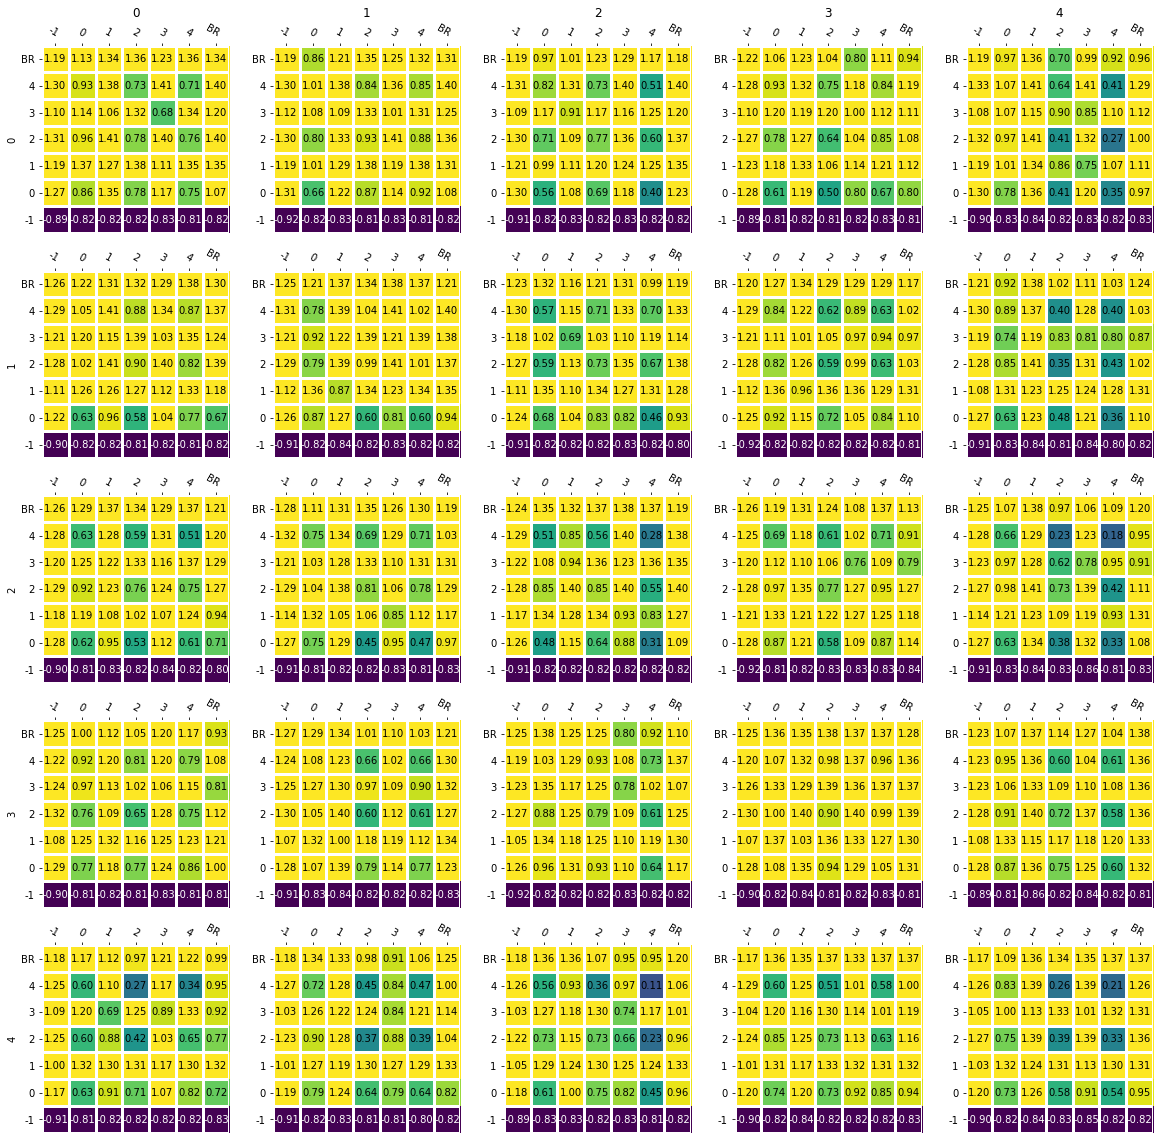

In [7]:
plot_pairwise_policy_comparison(
    rl_df, y_key="episode_discounted_returns_mean", vrange=(-0.2, 1.0), figsize=(20, 20), valfmt="{x:.2f}"
)

## RL average policy performance

Here we look at average performance of the policies learned using RL by themselves (without additional search).

Each plot shows the *mean performance* for the *row* policy against the *column* policy.

The **left-hand plot** shows *same-play* performance. So performance of policies against policies from the same training population (same training algorithm and same seed).

The **middle plot** shows *cross-play* performance. So performance of policies against policies from different training populations (against policies trained using a different algorithm and/or different seed).

The **right-hand plot** shows the generalization gap which is just the difference between the *Same-Play* and *Cross-Play* performance.

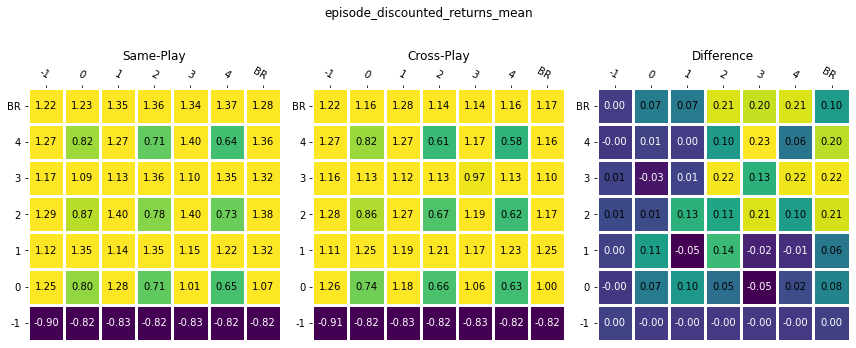

In [8]:
# NEW version
plot_rl_pw_comparison(rl_df, "episode_discounted_returns_mean", vrange=(-0.2, 1.0))
plt.show()

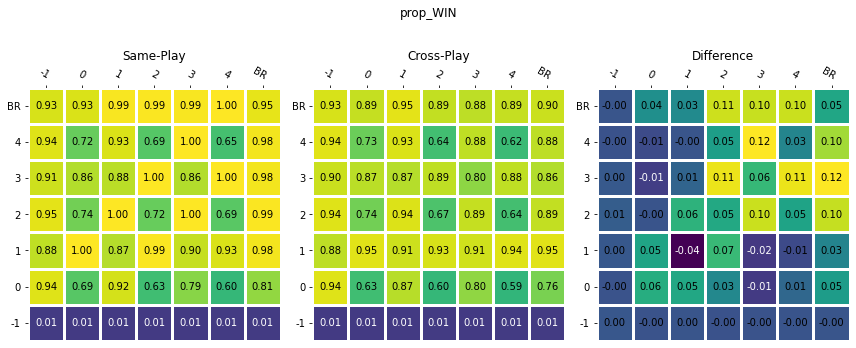

In [9]:
plot_rl_pw_comparison(rl_df, "prop_WIN", vrange=(0.0, 1.0))
plt.show()

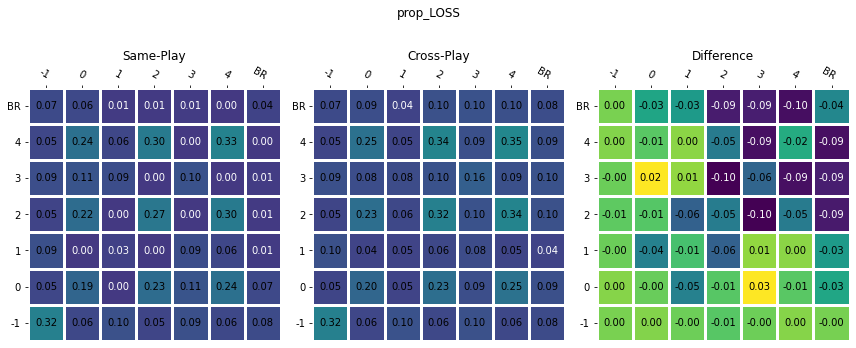

In [10]:
# Proportion of episodes the row agent crashed. I.e. the collision rate.
plot_rl_pw_comparison(rl_df, "prop_LOSS", vrange=(0.0, 0.4))
plt.show()

# Same-Play vs Cross-Play Explanation

Due to it's bootstrapping nature, Reinforcement Learning training can be unstable and can converge to very different final policies given the exact same algorithm and configuration but a different random seed (https://ojs.aaai.org/index.php/AAAI/article/view/11694). This is especially true for multi-agent reinforcement learning where the optimal policy for any agent depends on the policies of the other agents in the environment. When we have a population of RL agents all training at the same time, small differences in initial conditions at the start of training (i.e. different random seeds) can lead to big differences in the behaviour of the final policies.

We can use **Same-Play** and **Cross-Play** to properly evaluate the robustness of trained Multi-agent RL policies. This idea of same-play and cross-play has been used in a number of MARL papers:

Lanctot, Marc, Vinicius Zambaldi, Audrunas Gruslys, Angeliki Lazaridou, Karl Tuyls, Julien Pérolat, David Silver, and Thore Graepel. 2017. “A Unified Game-Theoretic Approach to Multiagent Reinforcement Learning.” ArXiv Preprint ArXiv:1711.00832.
Cui, Brandon, Hengyuan Hu, Luis Pineda, and Jakob Foerster. 2021. “K-Level Reasoning for Zero-Shot Coordination in Hanabi.” Advances in Neural Information Processing Systems 34.

The main idea behind Same-play and Cross-play is to train multiple populations of agents and then evaluate each population against each other population (including against itself). A population here is just a set of one or more policies that are related to each other in some way (think a connected network of agents). Each different population will be different in some way. For example we could have populations that are identical (i.e. use the same algorithm) except for the random seed, or populations that have the same random seed but use different algorithms or configuration. During training each population is completely independent of any other population. Only during evaluation, once training is complete and all policies are fixed, do policies from different populations interact.

## Training

As mentioned, during training we train multiple independent populations of agents. The specific form of a population and it's training protocol will depend on the algorithm being used. For example, *self-play* (not to be confused with same-play) will have a single policy that is trained against itself, while Synchronous K-Level Reasoning Best Response (SyKLRBR) (From the hanabi paper) for a K=2 has three policies (pi_BR, pi_1, pi_0) that are trained using the KLR setup.

So in the following example we have two populations of agents: *Population 1* and *Population 2*. Both populations are being trained using the SyKLRBR algorithm for K=2. The populations only differ in the random seed used at the beginning of training. This random seed impacts the random outcomes in the environment and also when randomly sampling actions from the policies (e.g. for stochastic policies and for exploration).

![alt text](figures/same_vs_cross_play_training.png "Title")

## After Training

Once training has finished (say after training for 1 million steps or 1000 episodes, etc), we are left with distinct sets of policies; one set per population.

![alt text](figures/same_vs_cross_play_after_training.png "Title")

## Evaluation

Now we can evaluate these sets of policies using **same-play** and **cross-play** by selecting policies from the different sets and then running evaluation episodes (e.g. 1000 episodes) where these policies interact in the same environment.

If the policies came from the same population, then it's **same-play**. If the policies are from different populations, then it's **cross-play**.

The difference in a policy's same-play and cross-play performance show us how robust the policy is. Or probably more accurately, how much the policy as overfit to it's own population. What we hope to find is an algorithm which results in populations that are able to perform well against agents from within the same population and agents from different populations.  

![alt text](figures/same_vs_cross_play_evaluation.png "Title")





# Example recorded episodes

(The next plots just show Experiment ID for each population, policy pairing. This is used to find visualizations of the different pairings and not for any results per se.)

The following are IDs of episodes recorded during the experiment that show interesting/representative behaviour:

Good playback speed = 0.1x (change with `[` and `]` keys)

#### Same-play  (NOT UPDATED)

##### The good

- pi_4 vs pi_3 (seed 0)- Exp 33 Episode 512: 
    - Shows agents both starting at bottom and pi_4 (blue) waiting for pi_3 (red) before going
- pi_BR vs pi_2 (seed 1) - Exp 272 Episode ?
    - Shows agents both starting at bottom and pi_BR (blue) waiting for pi_2 (red)  
- pi_BR vs pi_3 (seed 1) - Exp 279 Episode ?
    - Shows agents both starting at bottom and pi_BR (blue) waiting for pi_3 (red) 
- pi_BR vs pi_1 (seed 1) - Exp 265 Episode
    - Episode 125 - Shows agents both starting on right and pi_BR (blue) going before for pi_1 (red) 
    - Episode 729 - Shows agents both starting at bottom and pi_BR (blue) waiting for pi_1 (red) 

##### The bad

- pi_4 vs pi_4 (seed 0) - Exp 40 Episodes 1 and 64 
    - Shows agents starting on same side and crashing at narrow section (crash frame is not shown but episode terminates as agents move thru narrow section, indicating the episode ended there)
- pi_0 vs pi_0 (seed 1) - Exp 253 
    - Episodes 8 Shows agents starting on different sides but crashing when going to narrow section into the side where they both have goals.
    - Episodes 27 Shows agents starting on same side and crashing at narrowing. 

Not averaging duplicates. FYI.


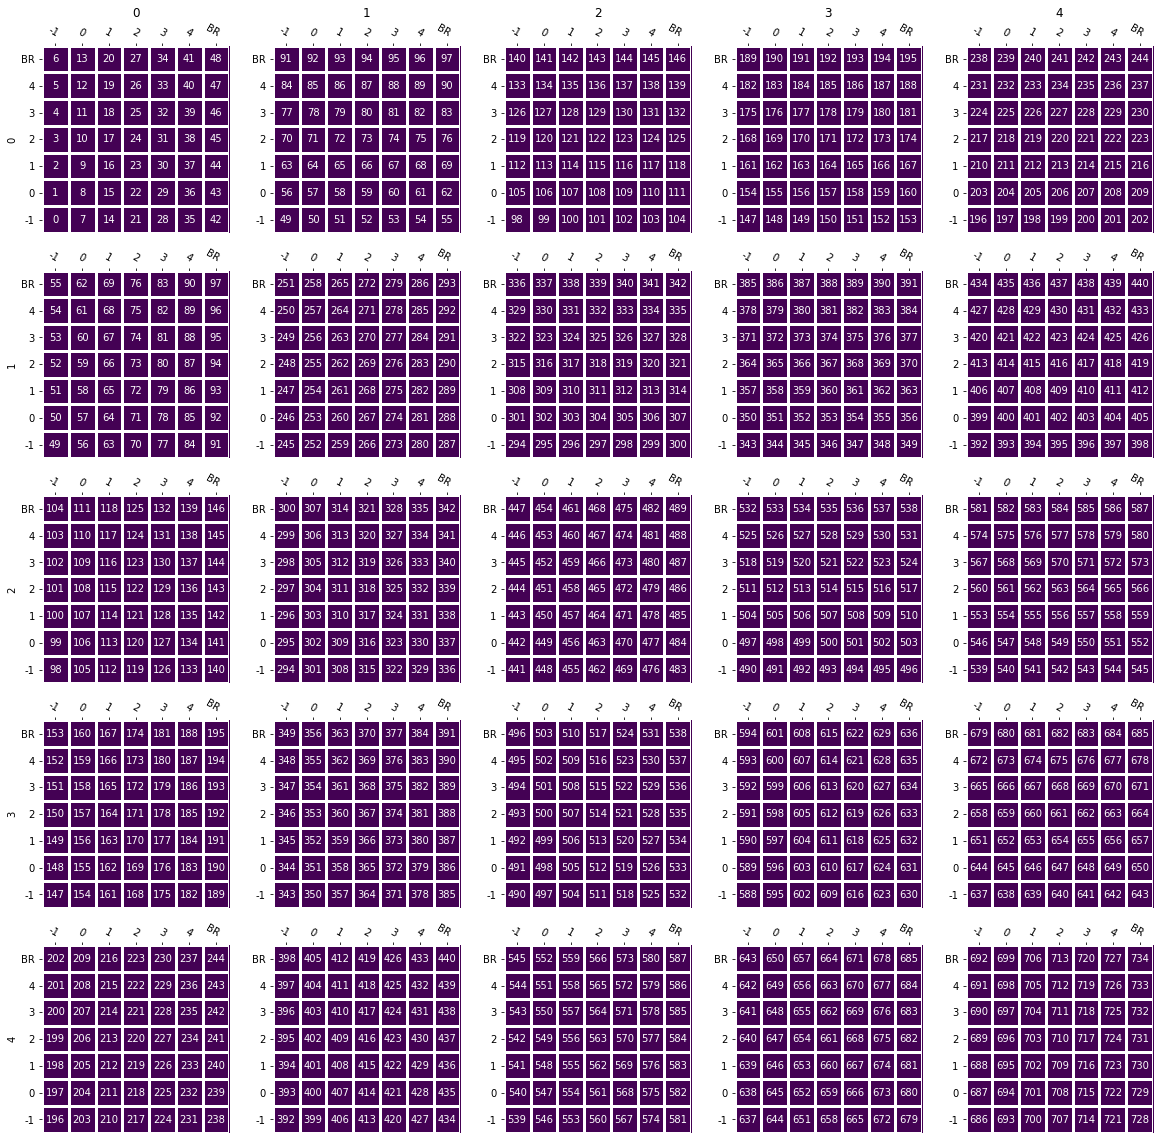

In [15]:
plot_pairwise_policy_comparison(
    rl_df, 
    y_key="exp_id", 
    vrange=(0.0, 0.0), 
    figsize=(20, 20), 
    valfmt="{x:.0f}", 
    average_duplicates=False
)